In [1]:
#Python libraries
!pip install tf2onnx

import matplotlib.pyplot as plt
#import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#check tensorflow version
print(tf.__version__)

2.12.0


In [4]:
#check GPU support
print(len(tf.config.list_physical_devices('GPU'))>0)

True


In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
##initialize MetaTrader5 for history data
#if not mt5.initialize():
#    print("initialize() failed, error code =",mt5.last_error())
#    quit()

In [7]:
#terminal_info=mt5.terminal_info()

In [8]:
#show file path
#file_path=terminal_info.data_path+"\\MQL5\\Files\\"

In [9]:
#file_path

In [10]:
#data path to save the model
data_path=argv[0]
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]


In [11]:
data_path

''

In [12]:
##set start and end dates for history data
#from datetime import timedelta,datetime
#end_date = datetime.now()
#start_date = end_date - timedelta(days=360)
#
##print start and end dates
#print("data start date=",start_date)
#print("data end date=",end_date)

In [13]:
##get EURUSD rates (H1) from start_date to end_date
##eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, start_date, end_date)
#eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_M6, start_date, end_date)

In [14]:
#check
#print(eurusd_rates)

In [15]:
#create dataframe
#df = pd.DataFrame(eurusd_rates)

In [16]:
#df.to_csv("..\..\data\EURUSD_20220720_to_20230715_M6.csv")

In [17]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/EURUSD_20220720_to_20230715_M6.csv')

In [18]:
#show dataframe head
df.head()

,Unnamed: 0,time,open,high,low,close,tick_volume,spread,real_volume
0,0,1658322360,1.02456,1.02493,1.02430,1.02431,544,0,0
1,1,1658322720,1.02429,1.02429,1.02366,1.02372,501,0,0
2,2,1658323080,1.02372,1.02385,1.02324,1.02347,538,0,0
3,3,1658323440,1.02346,1.02419,1.02296,1.02399,695,0,0
4,4,1658323800,1.02398,1.02402,1.02087,1.02112,1410,0,0


In [19]:
#show dataframe tail
df.tail()

,Unnamed: 0,time,open,high,low,close,tick_volume,spread,real_volume
61568,61568,1689370920,1.12340,1.12356,1.12334,1.12349,126,0,0
61569,61569,1689371280,1.12349,1.12362,1.12348,1.12361,149,0,0
61570,61570,1689371640,1.12361,1.12362,1.12326,1.12341,384,0,0
61571,61571,1689372000,1.12342,1.12342,1.12302,1.12305,213,0,0
61572,61572,1689372360,1.12306,1.12312,1.12302,1.12303,20,0,0


In [20]:
#show dataframe shape (the number of rows and columns in the data set)
df.shape

(61573, 9)

In [21]:
#prepare close prices only
data = df.filter(['close']).values

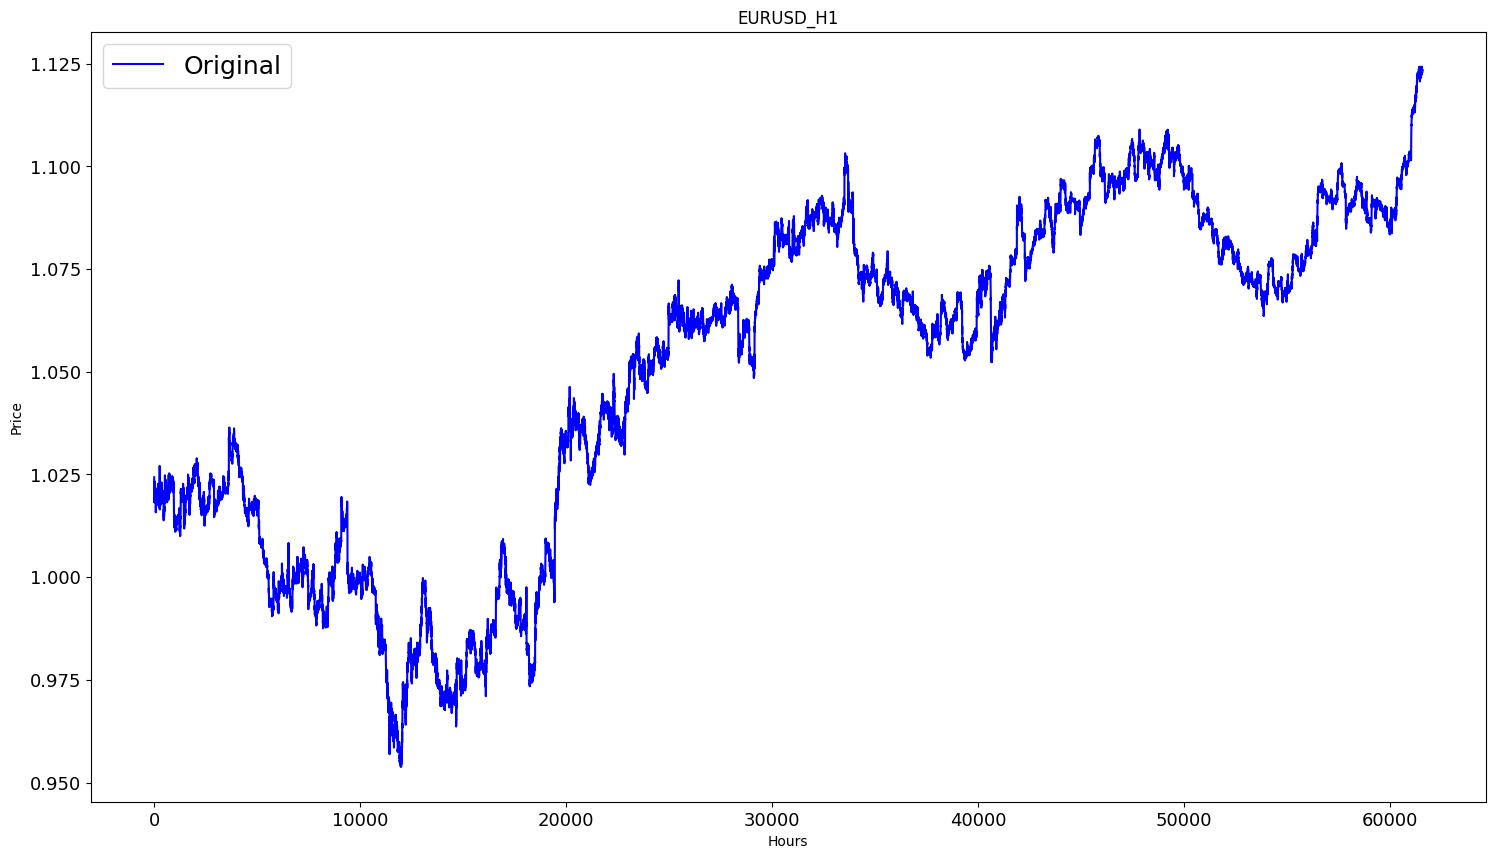

In [22]:
#show close prices
plt.figure(figsize = (18,10))
plt.plot(data,'b',label = 'Original')
plt.xlabel("Hours")
plt.xticks(fontsize=13)
plt.ylabel("Price")
plt.yticks(fontsize=13)
plt.title("EURUSD_H1")
plt.legend(fontsize=18)

In [23]:
#scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [24]:
#training size is 80% of the data
training_size = int(len(scaled_data)*0.80)
print("training size:",training_size)

training size: 49258


In [25]:
#create train data and check size
train_data_initial = scaled_data[0:training_size,:]
print(len(train_data_initial))

49258


In [26]:
#create test data and check size
test_data_initial= scaled_data[training_size:,:1]
print(len(test_data_initial))

12315


In [27]:
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       #find the end of this pattern
       end_ix = i + n_steps
       #check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       #gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [28]:
#split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)

In [29]:
#reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [30]:
#show shape of train data
x_train.shape

(49138, 120, 1)

In [31]:
#show shape of test data
x_test.shape

(12195, 120, 1)

In [32]:
#import keras libraries for the model
import math
#import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv1D,MaxPooling1D,Dropout
from keras.layers import LSTM
#from tf.keras.utils.vis_utils import plot_model
from keras.utils import plot_model
from keras.metrics import RootMeanSquaredError as rmse
from keras import optimizers

In [33]:
#define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

In [34]:
#show model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 256)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 256)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 60, 100)           142800    
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [35]:
#measure time
import time
time_calc_start = time.time()

#fit model with 300 epochs
history=model.fit(x_train,y_train,epochs=300,validation_data=(x_test,y_test),batch_size=32,verbose=1)

#calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =",fit_time_seconds," seconds.")

Epoch 1/300
1536/1536 [==============================] - 39s 17ms/step - loss: 8.6719e-04 - root_mean_squared_error: 0.0294 - val_loss: 1.2391e-04 - val_root_mean_squared_error: 0.0111
Epoch 2/300
1536/1536 [==============================] - 16s 11ms/step - loss: 2.7045e-04 - root_mean_squared_error: 0.0164 - val_loss: 8.9782e-05 - val_root_mean_squared_error: 0.0095
Epoch 3/300
1536/1536 [==============================] - 16s 11ms/step - loss: 2.4458e-04 - root_mean_squared_error: 0.0156 - val_loss: 3.4277e-04 - val_root_mean_squared_error: 0.0185
Epoch 4/300
1536/1536 [==============================] - 16s 11ms/step - loss: 2.3115e-04 - root_mean_squared_error: 0.0152 - val_loss: 1.0793e-04 - val_root_mean_squared_error: 0.0104
Epoch 5/300
1536/1536 [==============================] - 17s 11ms/step - loss: 2.2849e-04 - root_mean_squared_error: 0.0151 - val_loss: 7.9607e-05 - val_root_mean_squared_error: 0.0089
Epoch 6/300
1536/1536 [==============================] - 20s 13ms/step - lo

In [36]:
#show training history keys
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

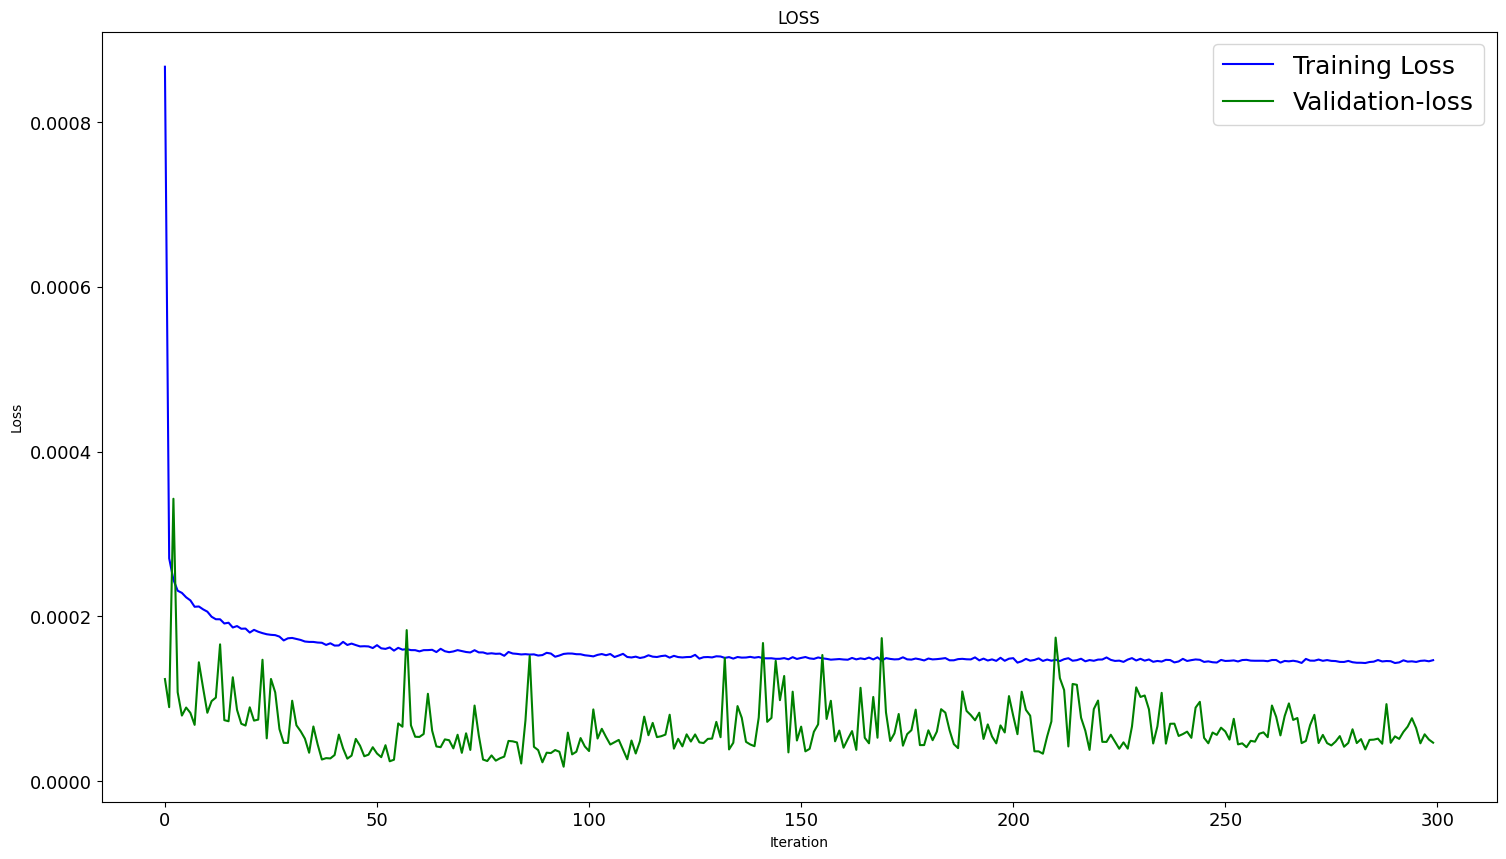

In [37]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("LOSS")
plt.legend(fontsize=18)

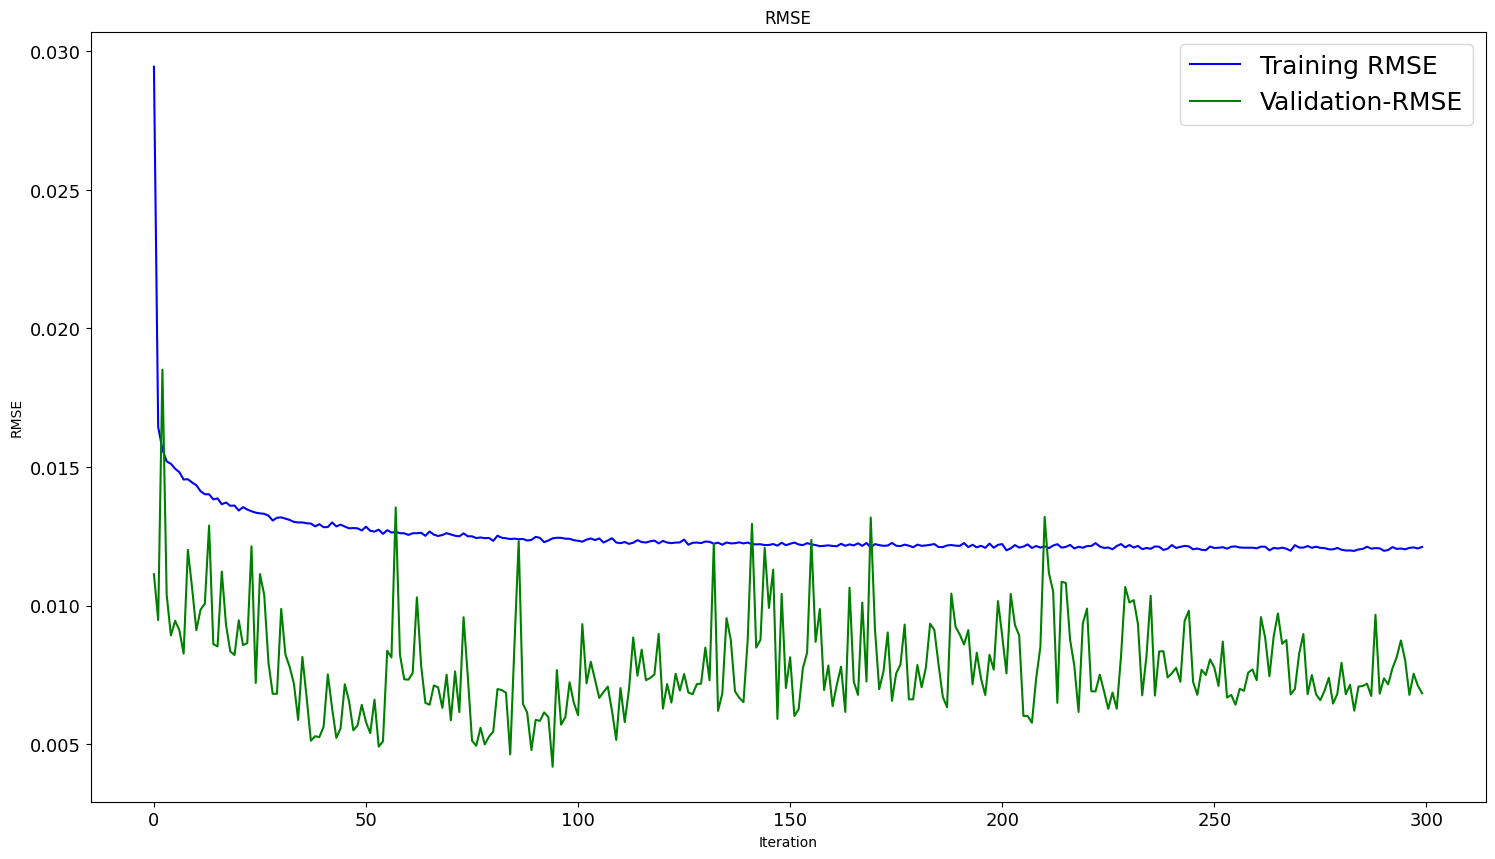

In [49]:
#show iteration-rmse graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['root_mean_squared_error'],label='Training RMSE',color='b')
plt.plot(history.history['val_root_mean_squared_error'],label='Validation-RMSE',color='g')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("RMSE")
plt.legend(fontsize=18)

In [50]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

1536/1536 [==============================] - 8s 5ms/step - loss: 8.4267e-06 - root_mean_squared_error: 0.0029


[8.426650310866535e-06, 0.0029028693679720163]

In [51]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

382/382 [==============================] - 2s 5ms/step - loss: 4.6687e-05 - root_mean_squared_error: 0.0068


[4.668730980483815e-05, 0.006832811050117016]

In [55]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

1536/1536 [==============================] - 7s 4ms/step


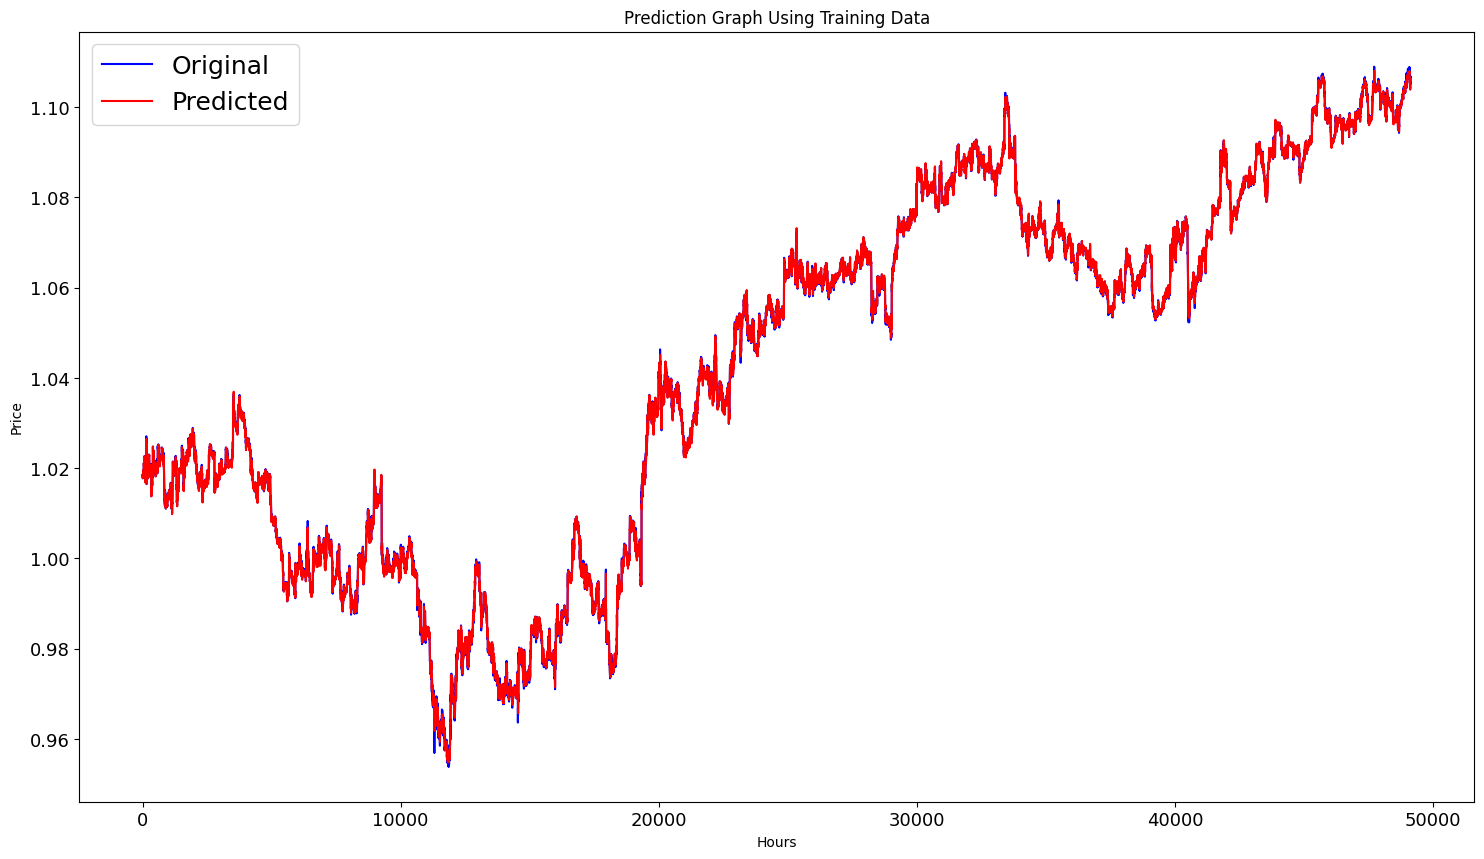

In [56]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [57]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

382/382 [==============================] - 1s 4ms/step


In [58]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 0.0011643097813582382
MSE          : 1.3556172669664686e-06
R2 score     : 0.9906596322233348


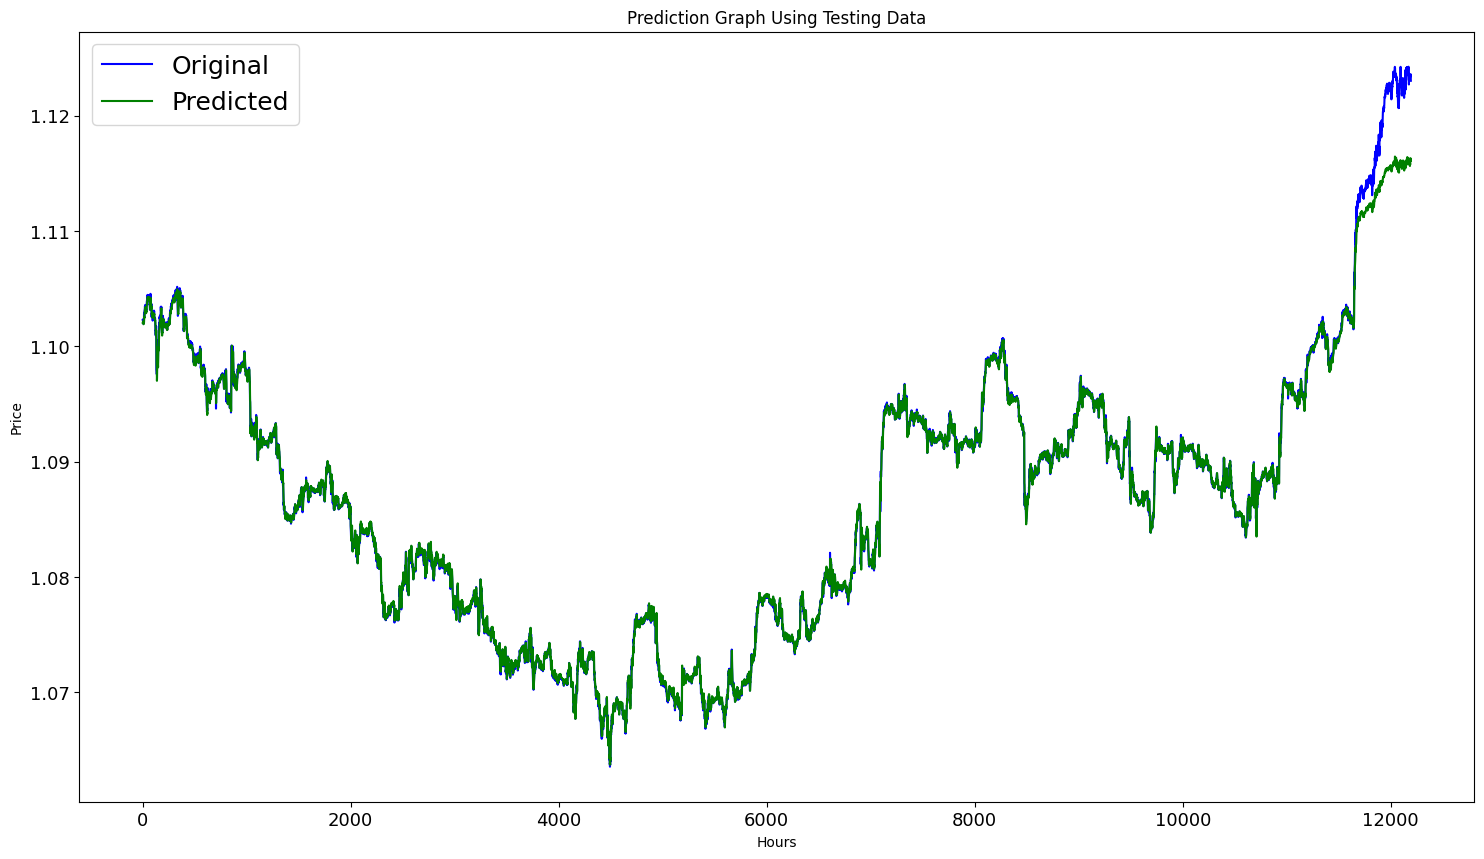

In [59]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [60]:
# save model to ONNX
#output_path = data_path+"model.eurusd.H1.120.onnx"
#output_path = data_path+"model.eurusd.M6.120.onnx"

output_path = '/content/drive/MyDrive/Colab Notebooks/data/onnx/model.eurusd.M6.120.onnx'

onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)

In [ ]:
# finish
#mt5.shutdown()